In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import class_weight

import seaborn as sns
import matplotlib as plt

from tensorflow.keras.callbacks import EarlyStopping

In [5]:
data = pd.read_csv('training_data/eurusd_final_dataset.csv')

# I am dropping because I don't want to use these features in the model currently
X = data.drop(['label', 'Date_Time', 'hour', 'dayofweek', 'mins_into_m15', 'frac_into_m15'], axis=1)
y = data['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

#### Attempting to create a NN with the whole data set, using changed weights - Failed

In [33]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

# Use the integer version of the labels here
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dict if needed
class_weights = dict(enumerate(class_weights))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train_cat, class_weight=class_weights, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
3837/3837 [==============================] - 18s 4ms/step - loss: 1.3467 - accuracy: 0.5228 - val_loss: 1.1866 - val_accuracy: 0.5386
Epoch 2/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3235 - accuracy: 0.5433 - val_loss: 1.1862 - val_accuracy: 0.5391
Epoch 3/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3177 - accuracy: 0.5461 - val_loss: 1.1504 - val_accuracy: 0.5503
Epoch 4/20
3837/3837 [==============================] - 17s 5ms/step - loss: 1.3141 - accuracy: 0.5454 - val_loss: 1.1737 - val_accuracy: 0.5368
Epoch 5/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3116 - accuracy: 0.5467 - val_loss: 1.1710 - val_accuracy: 0.5512
Epoch 6/20
3837/3837 [==============================] - 17s 4ms/step - loss: 1.3090 - accuracy: 0.5458 - val_loss: 1.1620 - val_accuracy: 0.5509
Epoch 7/20
3837/3837 [==============================] - 17s 5ms/step - loss: 1.3082 - accuracy: 0.5461 - val_loss: 1.1455 - val_ac

In [ ]:
# Predict
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics
print("Keras Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
#plt.xlabel("Predicted")
#plt.ylabel("True")
#plt.show()

# Per-class Precision/Recall/F1
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
for i in range(5):
    print(f"Class {i} — Precision: {prec[i]:.2f}, Recall: {rec[i]:.2f}, F1: {f1[i]:.2f}")

1066/1066 [==============================] - 3s 3ms/step
Keras Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     16072
           1       0.50      0.40      0.44     12110
           2       0.26      0.33      0.29      3738
           3       0.16      0.31      0.21      1243
           4       0.24      0.28      0.26       941

    accuracy                           0.55     34104
   macro avg       0.38      0.41      0.39     34104
weighted avg       0.57      0.55      0.56     34104

Confusion Matrix:
Class 0 — Precision: 0.75, Recall: 0.75, F1: 0.75
Class 1 — Precision: 0.50, Recall: 0.40, F1: 0.44
Class 2 — Precision: 0.26, Recall: 0.33, F1: 0.29
Class 3 — Precision: 0.16, Recall: 0.31, F1: 0.21
Class 4 — Precision: 0.24, Recall: 0.28, F1: 0.26


In [ ]:
# Simulated trade logic example: TP = +2, SL = -1 per class prediction
profit_rules = {0: 2, 1: -1, 2: 2, 3: -1, 4: 0}

# Assume true class is the correct "direction" — reward if prediction matches
profits = [profit_rules[p] if p == t else -1 for p, t in zip(y_pred, y_test)]
total_profit = sum(profits)

print(f"Simulated Profit: {total_profit}")

#### Attempting to create an NN but with rolling window

In [6]:
window_size = 5000   # How many initial samples to train on
val_size = 1000      # Evaluate every 1000 samples
step = 1000          # Step forward by 1000 each round

all_preds = []
all_trues = []

for start in range(0, len(X_scaled) - window_size - val_size, step):
    # Define train and validation ranges
    train_X = X_scaled[start : start + window_size]
    val_X   = X_scaled[start + window_size : start + window_size + val_size]

    train_y = y[start : start + window_size]
    val_y   = y[start + window_size : start + window_size + val_size]

    # One-hot encode
    train_y_cat = to_categorical(train_y, num_classes=5)
    val_y_cat   = to_categorical(val_y, num_classes=5)

    # Compute class weights for current window
    weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_y),
        y=train_y
    )
    cw = dict(enumerate(weights))

    # Build new model for each window (fresh start)
    model = Sequential([
        Dense(64, activation='relu', input_shape=(train_X.shape[1],)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

    # Train
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=50,
              batch_size=32,
              class_weight=cw,
              callbacks=[es],
              verbose=1)

    # Predict
    pred_prob = model.predict(val_X)
    preds = np.argmax(pred_prob, axis=1)

    all_preds.extend(preds)
    all_trues.extend(val_y)

# Evaluate final performance
print("Walk-forward Evaluation:")
print(classification_report(all_trues, all_preds))
print("Confusion Matrix:")
print(confusion_matrix(all_trues, all_preds))

Epoch 1/50
157/157 [==============================] - 2s 7ms/step - loss: 1.4992 - accuracy: 0.2880 - val_loss: 1.4710 - val_accuracy: 0.3480
Epoch 2/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3651 - accuracy: 0.3686 - val_loss: 1.3559 - val_accuracy: 0.3560
Epoch 3/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3321 - accuracy: 0.4088 - val_loss: 1.3333 - val_accuracy: 0.3780
Epoch 4/50
157/157 [==============================] - 1s 4ms/step - loss: 1.3091 - accuracy: 0.4150 - val_loss: 1.3702 - val_accuracy: 0.3540
Epoch 5/50
157/157 [==============================] - 1s 5ms/step - loss: 1.3042 - accuracy: 0.4018 - val_loss: 1.3680 - val_accuracy: 0.3610
Epoch 6/50
157/157 [==============================] - 1s 5ms/step - loss: 1.2917 - accuracy: 0.4066 - val_loss: 1.3340 - val_accuracy: 0.3740
Epoch 7/50
157/157 [==============================] - 1s 5ms/step - loss: 1.2795 - accuracy: 0.4116 - val_loss: 1.3492 - val_accuracy: 0.3650
Epoch 

In [7]:
# --- Parameters ---
window_size = 5000
val_size = 1000
step = 1000

# --- Model builder ---
def build_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --- Walk-forward logic ---
model = None
all_preds = []
all_trues = []

from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

f1_per_window = []
acc_per_window = []
window_indices = []

for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size, step)):
    # Same setup as before...
    train_X = X_scaled[start : start + window_size]
    val_X   = X_scaled[start + window_size : start + window_size + val_size]
    train_y = y[start : start + window_size]
    val_y   = y[start + window_size : start + window_size + val_size]

    train_y_cat = to_categorical(train_y, num_classes=5)
    val_y_cat   = to_categorical(val_y, num_classes=5)

    cw = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_y),
        y=train_y
    )))

    if model is None:
        model = build_model(train_X.shape[1])

    es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=30,
              batch_size=32,
              class_weight=cw,
              callbacks=[es],
              verbose=0)

    # Predict
    pred_prob = model.predict(val_X, verbose=0)
    preds = np.argmax(pred_prob, axis=1)

    all_preds.extend(preds)
    all_trues.extend(val_y)

    # 🔍 Log per-window metrics
    f1 = f1_score(val_y, preds, average='weighted')
    acc = accuracy_score(val_y, preds)
    f1_per_window.append(f1)
    acc_per_window.append(acc)
    window_indices.append(i)

    print(f"Window {i}: F1 = {f1:.4f}, Accuracy = {acc:.4f}")

c:\Users\marti\anaconda3\envs\quant-trading\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Window 0: F1 = 0.3695, Accuracy = 0.4020
Window 1: F1 = 0.4341, Accuracy = 0.4540
Window 2: F1 = 0.4321, Accuracy = 0.4310
Window 3: F1 = 0.5002, Accuracy = 0.5010
Window 4: F1 = 0.4635, Accuracy = 0.4640
Window 5: F1 = 0.4299, Accuracy = 0.4750
Window 6: F1 = 0.3811, Accuracy = 0.3930
Window 7: F1 = 0.4215, Accuracy = 0.4170
Window 8: F1 = 0.3010, Accuracy = 0.2880
Window 9: F1 = 0.2984, Accuracy = 0.3210
Window 10: F1 = 0.4314, Accuracy = 0.4320
Window 11: F1 = 0.3764, Accuracy = 0.3700
Window 12: F1 = 0.4622, Accuracy = 0.4830
Window 13: F1 = 0.4886, Accuracy = 0.5010
Window 14: F1 = 0.3709, Accuracy = 0.3990
Window 15: F1 = 0.3569, Accuracy = 0.3740
Window 16: F1 = 0.4011, Accuracy = 0.4370
Window 17: F1 = 0.4755, Accuracy = 0.4970
Window 18: F1 = 0.4623, Accuracy = 0.4810
Window 19: F1 = 0.4304, Accuracy = 0.4540
Window 20: F1 = 0.5674, Accuracy = 0.5610
Window 21: F1 = 0.5025, Accuracy = 0.5060
Window 22: F1 = 0.5351, Accuracy = 0.4990
Window 23: F1 = 0.4756, Accuracy = 0.4820
Wi

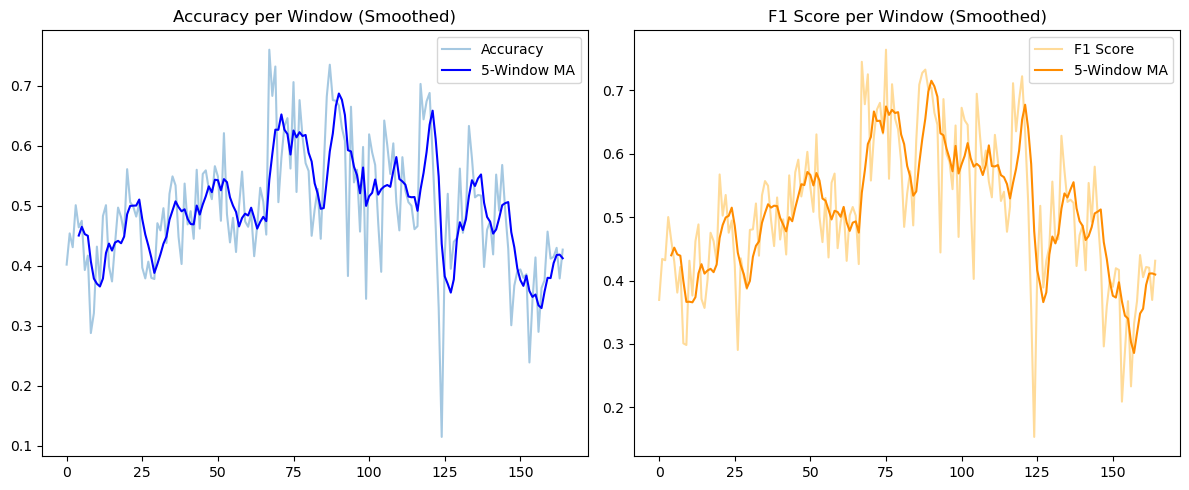

In [9]:
import pandas as pd

f1_ma = pd.Series(f1_per_window).rolling(5).mean()
acc_ma = pd.Series(acc_per_window).rolling(5).mean()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(window_indices, acc_per_window, label='Accuracy', alpha=0.4)
plt.plot(window_indices, acc_ma, label='5-Window MA', color='blue')
plt.title("Accuracy per Window (Smoothed)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(window_indices, f1_per_window, label='F1 Score', alpha=0.4, color='orange')
plt.plot(window_indices, f1_ma, label='5-Window MA', color='darkorange')
plt.title("F1 Score per Window (Smoothed)")
plt.legend()

plt.tight_layout()
plt.show()
